# PROBLEM STATEMENT

Data assimilation are numerical methods used in geosciences to mix the information of observations (noted as $y$) and a dynamical model (noted as $f$) in order to estimate the true/hidden state of the system (noted as $x$) at every time step $k$. Usually, they are related following a nonlinear state-space model:
<img src=https://tandeo.files.wordpress.com/2019/02/formule_nnss_model.png width="200">
with $\eta$ and $\epsilon$ some independant white Gaussian noises respectively respresenting the model forecast error and the error of observation.

In classical data assimilation, we require multiple runs of an explicit dynamical model $f$ with possible severe limitations including the computational cost, the lack of consistency of the model with respect to the observed data as well as modeling uncertainties. Here, an alternative strategy is explored by developing a fully data-driven assimilation. No explicit knowledge of the dynamical model is required. Only a representative catalog of trajectories of the system is assumed to be available. Based on this catalog, the Analog Data Assimilation (AnDA) is introduced by combining machine learning with the analog method (or nearest neighbor search) and stochastic assimilation techniques including Ensemble Kalman Filter and Smoother (EnKF, EnKS) and Particle Filter (PF). We test the accuracy of the technic on different chaotic dynamical models, the Lorenz-63 and Lorenz-96 systems.

This Python library is attached to the following publication:
Lguensat, R., Tandeo, P., Ailliot, P., Pulido, M., & Fablet, R. (2017). The Analog Data Assimilation. *Monthly Weather Review*, 145(10), 4093-4107.
If you use this library, please do not forget to cite our work.

# IMPORT MODULES

Here, we import the different Python libraries and modules. In order to use the analog methog (or nearest neighboor search), we need to install the "scikit-learn" library (available at http://scikit-learn.org/). You also need to download the "tqdm" library to display the progress bar (available at https://tqdm.github.io/). Both libraries can be installed using pip or conda.

In [15]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

# analog data assimilation
from AnDA_codes.AnDA_generate_data import AnDA_generate_data
from AnDA_codes.AnDA_analog_forecasting import AnDA_analog_forecasting
from AnDA_codes.AnDA_model_forecasting import AnDA_model_forecasting
from AnDA_codes.AnDA_data_assimilation import AnDA_data_assimilation
from AnDA_codes.AnDA_stat_functions import AnDA_RMSE

# 3D plots
from mpl_toolkits.mplot3d import Axes3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


# TEST ON LORENZ-63

To begin, as dynamical model $f$, we use the Lorenz-63 chaotic system. First, we generate simulated trajectories from this dynamical model and store them into the catalog. Then, we use this catalog to emulate the dynamical model and we apply the analog data assimilation. Finally, we compare the results of this data-driven approach to the classical data assimilation (using the true Lorenz-63 equations as dynamical model).

In [16]:
### GENERATE SIMULATED DATA (LORENZ-63 MODEL)

# parameters
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8 # number of integration times between consecutive observations (for yo)
    var_obs = np.array([0]) # indices of the observed variables
    nb_loop_train = 10**2 # size of the catalog
    nb_loop_test = 10 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = AnDA_generate_data(GD)

######################
SAMPLE OF THE CATALOG:
######################
Analog (t1): [ -6.74567305 -11.71049764  14.06288781] Successor (t1+dt): [ -7.2584588  -12.54878085  14.53106045]
Analog (t2): [-12.86572196 -18.97891191  24.89152202] Successor (t2+dt): [-13.45405869 -19.07782146  26.71109123]
Analog (t3): [-14.28302895  -9.42748816  39.11457349] Successor (t3+dt): [-13.74028474  -7.76873648  39.27440222]


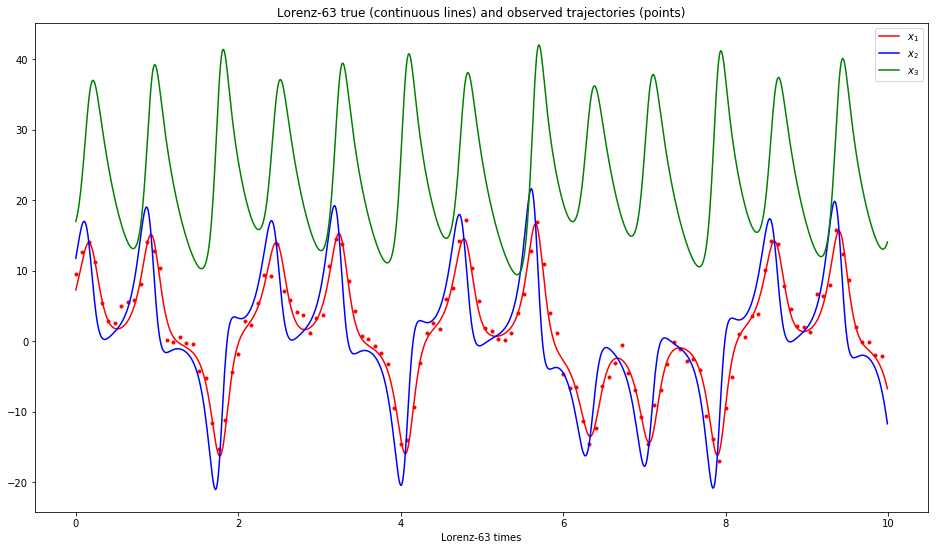

In [17]:
### PLOT STATE, OBSERVATIONS AND CATALOG

# state and observations (when available)
line1,=plt.plot(xt.time,xt.values[:,0],'-r');plt.plot(yo.time,yo.values[:,0],'.r')
line2,=plt.plot(xt.time,xt.values[:,1],'-b');plt.plot(yo.time,yo.values[:,1],'.b')
line3,=plt.plot(xt.time,xt.values[:,2],'-g');plt.plot(yo.time,yo.values[:,2],'.g')
plt.xlabel('Lorenz-63 times')
plt.legend([line1, line2, line3], ['$x_1$', '$x_2$', '$x_3$'])
plt.title('Lorenz-63 true (continuous lines) and observed trajectories (points)')

# catalog sample of simulated trajectories
print('######################')
print('SAMPLE OF THE CATALOG:')
print('######################')
print('Analog (t1): ' + str(catalog.analogs[0,:]), end=" ")
print('Successor (t1+dt): ' + str(catalog.successors[0,:]))
print('Analog (t2): ' + str(catalog.analogs[10,:]), end=" ")
print('Successor (t2+dt): ' + str(catalog.successors[10,:]))
print('Analog (t3): ' + str(catalog.analogs[20,:]), end=" ")
print('Successor (t3+dt): ' + str(catalog.successors[20,:]))

In [18]:
### ANALOG DATA ASSIMILATION (dynamical model given by the catalog)

# parameters of the analog forecasting method
class AF:
    k = 50 # number of analogs
    neighborhood = np.ones([xt.values.shape[1],xt.values.shape[1]]) # global analogs
    catalog = catalog # catalog with analogs and successors
    regression = 'local_linear' # chosen regression ('locally_constant', 'increment', 'local_linear')
    sampling = 'gaussian' # chosen sampler ('gaussian', 'multinomial')

# parameters of the filtering method
class DA:
    method = 'AnEnKS' # chosen method ('AnEnKF', 'AnEnKS', 'AnPF')
    N = 100 # number of members (AnEnKF/AnEnKS) or particles (AnPF)
    xb = xt.values[0,:]; B = 0.1*np.eye(xt.values.shape[1])
    H = np.eye(xt.values.shape[1])
    R = GD.sigma2_obs*np.eye(xt.values.shape[1])
    @staticmethod
    def m(x):
        return AnDA_analog_forecasting(x,AF)
    
# run the analog data assimilation
x_hat_analog = AnDA_data_assimilation(yo, DA)

100%|██████████| 1000/1000 [00:03<00:00, 253.82it/s]


In [21]:
### CLASSICAL DATA ASSIMILATION (dynamical model given by the equations)
    
# parameters of the filtering method
class DA:
    method = 'AnEnKS' # chosen method ('AnEnKF', 'AnEnKS', 'AnPF')
    N = 100 # number of members (AnEnKF/AnEnKS) or particles (AnPF)
    xb = xt.values[0,:]; B = 0.1*np.eye(xt.values.shape[1])
    H = np.eye(xt.values.shape[1])
    R = GD.sigma2_obs*np.eye(xt.values.shape[1])
    @staticmethod
    def m(x):
        return AnDA_model_forecasting(x,GD)
    
# run the classical data assimilation
x_hat_classical = AnDA_data_assimilation(yo, DA)

100%|██████████| 1000/1000 [00:00<00:00, 2506.28it/s]


RMSE(analog DA)    = 0.528114380465
RMSE(classical DA) = 0.450843120077


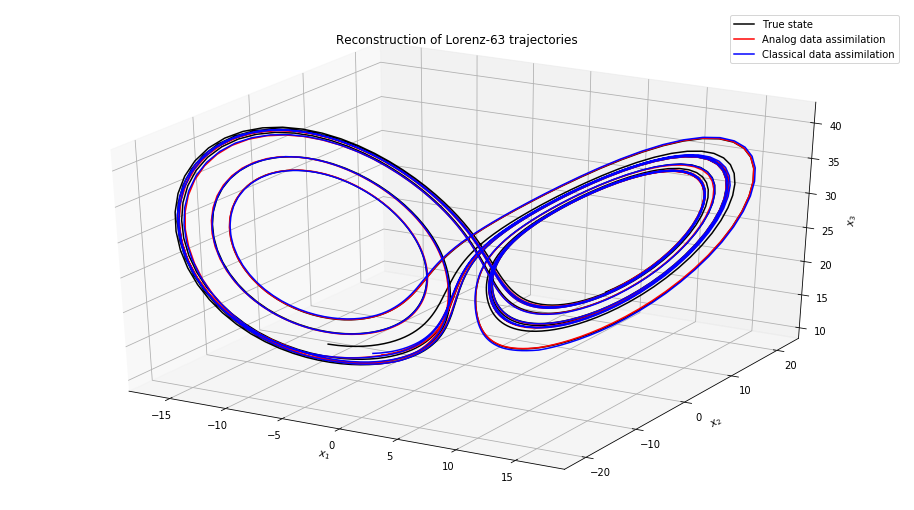

In [22]:
### COMPARISON BETWEEN CLASSICAL AND ANALOG DATA ASSIMILATION

# plot
fig=plt.figure()
ax=fig.gca(projection='3d')
line1,=ax.plot(xt.values[:,0],xt.values[:,1],xt.values[:,2],'k')
line2,=ax.plot(x_hat_analog.values[:,0],x_hat_analog.values[:,1],x_hat_analog.values[:,2],'r')
line3,=ax.plot(x_hat_classical.values[:,0],x_hat_classical.values[:,1],x_hat_classical.values[:,2],'b')
ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1, line2, line3], ['True state', 'Analog data assimilation', 'Classical data assimilation'])
plt.title('Reconstruction of Lorenz-63 trajectories')

# error
print('RMSE(analog DA)    = ' + str(AnDA_RMSE(xt.values,x_hat_analog.values)))
print('RMSE(classical DA) = ' + str(AnDA_RMSE(xt.values,x_hat_classical.values)))

The results show that performances of the data-driven analog data assimilation are closed to those of the model-driven data assimilation. The error can be reduced by augmenting the size of the catalog "nb_loop_train".

# TEST ON LORENZ-96

We also test the analog data assimilation procedure on the 40-dimensional Lorenz-96 dynamical model. As in the previous experiment, we generate state and observation data as well as simulated trajectories of the Lorenz-96 model in order to emulate the dynamical model. Here, we compare two analog data assimilation strategies: the global and local analog forecasting, respectively defined in finding similar situations on the whole 40 variables or on 5 variables recursively.

In [24]:
### GENERATE SIMULATED DATA (LORENZ-96 MODEL)

# parameters
class GD:
    model = 'Lorenz_96'
    class parameters:
        F = 8
        J = 40
    dt_integration = 0.05 # integration time
    dt_states = 1 # number of integration times between consecutive states (for xt and catalog)
    dt_obs = 4 # number of integration times between consecutive observations (for yo)
    var_obs = np.random.permutation(parameters.J)[0:20] # indices of the observed variables
    nb_loop_train = 10**2 # size of the catalog
    nb_loop_test = 10 # size of the true state and noisy observations
    sigma2_catalog = 0   # variance of the model error to generate the catalog   
    sigma2_obs = 2 # variance of the observation error to generate observations
    
# run the data generation
catalog, xt, yo = AnDA_generate_data(GD)

#############################################
SAMPLE OF THE CATALOG (only x_1, x_20, x_40):
#############################################
Analog (t1): [ 3.78297635 -1.03407769  3.24575275] Successor (t1+dt): [ 3.79854386 -0.48958006  3.18850079]
Analog (t2): [-4.45354973  7.8466197   7.5309293 ] Successor (t2+dt): [-3.86229277  7.80764413  6.98589131]
Analog (t3): [ 1.09889733 -1.79274725 -0.7682435 ] Successor (t3+dt): [ 1.49714129 -2.13318626 -0.33947353]


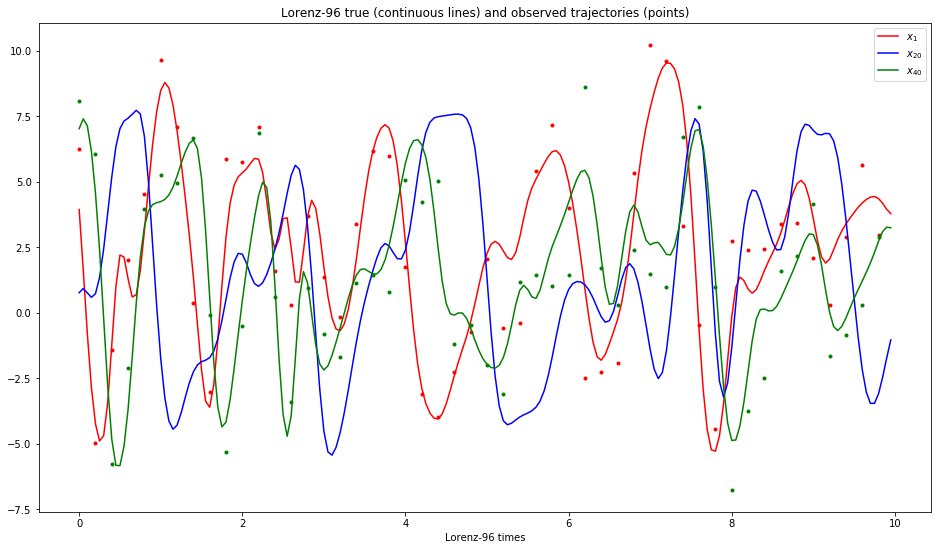

In [25]:
### PLOT STATE, OBSERVATIONS AND CATALOG

# state and observations (when available)
i_good_var=array([0,19,39])
line1,=plt.plot(xt.time,xt.values[:,0],'-r');plt.plot(yo.time,yo.values[:,0],'.r')
line2,=plt.plot(xt.time,xt.values[:,19],'-b');plt.plot(yo.time,yo.values[:,19],'.b')
line3,=plt.plot(xt.time,xt.values[:,39],'-g');plt.plot(yo.time,yo.values[:,39],'.g')
plt.xlabel('Lorenz-96 times')
plt.legend([line1, line2, line3], ['$x_1$', '$x_{20}$', '$x_{40}$'])
plt.title('Lorenz-96 true (continuous lines) and observed trajectories (points)')

# catalog sample of simulated trajectories (only for 3 variables)
print('#############################################')
print('SAMPLE OF THE CATALOG (only x_1, x_20, x_40):')
print('#############################################')
print('Analog (t1): ' + str(catalog.analogs[0,i_good_var]), end=" ")
print('Successor (t1+dt): ' + str(catalog.successors[0,i_good_var]))
print('Analog (t2): ' + str(catalog.analogs[15,i_good_var]), end=" ")
print('Successor (t2+dt): ' + str(catalog.successors[15,i_good_var]))
print('Analog (t3): ' + str(catalog.analogs[30,i_good_var]), end=" ")
print('Successor (t3+dt): ' + str(catalog.successors[30,i_good_var]))

Text(0.5,1,'Matrix of local analogs (white=0, black=1)')

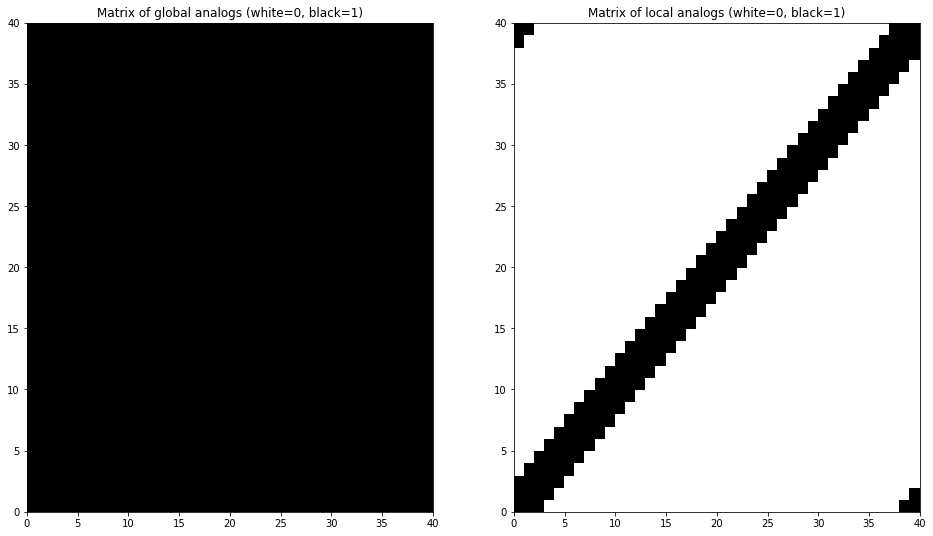

In [26]:
# global neighborhood (40 variables)
global_analog_matrix=np.ones([xt.values.shape[1],xt.values.shape[1]])

# local neighborhood (5 variables)
local_analog_matrix=np.eye(xt.values.shape[1])+np.diag(np.ones(xt.values.shape[1]-1),1)+ np.diag(np.ones(xt.values.shape[1]-1),-1)+ \
                   np.diag(np.ones(xt.values.shape[1]-2),2)+np.diag(np.ones(xt.values.shape[1]-2),-2)+\
                   np.diag(np.ones(xt.values.shape[1]-(GD.parameters.J-2)),GD.parameters.J-2)+np.diag(np.ones(xt.values.shape[1]-(GD.parameters.J-2)),GD.parameters.J-2).T+\
                   np.diag(np.ones(xt.values.shape[1]-(GD.parameters.J-1)),GD.parameters.J-1)+np.diag(np.ones(xt.values.shape[1]-(GD.parameters.J-1)),GD.parameters.J-1).T

# plot
subplot(1,2,1);pcolor(global_analog_matrix,cmap='Greys');clim([0,1]);title('Matrix of global analogs (white=0, black=1)')
subplot(1,2,2);pcolor(local_analog_matrix,cmap='Greys');clim([0,1]);title('Matrix of local analogs (white=0, black=1)')

To define the local or global analog forecasting, we generate different matrices that will be use as the "AF.neighborhood" argument. For each variable of the system, we use 0 or 1 to indicate the absence or presence of other variables in the analog forecasting procedure. For instance, in the local analog matrix defined above, to predict the variable $x_2$ at time t+dt, we will use the local variables $x_1$, $x_2$, $x_3$, $x_4$ and $x_{40}$ at time t.

In [27]:
### ANALOG DATA ASSIMILATION (with the global analogs)

# parameters of the analog forecasting method
class AF:
    k = 100; # number of analogs
    neighborhood = global_analog_matrix # global analogs
    catalog = catalog # catalog with analogs and successors
    regression = 'local_linear' # chosen regression ('locally_constant', 'increment', 'local_linear')
    sampling = 'gaussian' # chosen sampler ('gaussian', 'multinomial')

# parameters of the filtering method
class DA:
    method = 'AnEnKS' # chosen method ('AnEnKF', 'AnEnKS', 'AnPF')
    N = 500 # number of members (AnEnKF/AnEnKS) or particles (AnPF)
    xb = xt.values[0,:]; B = 0.1*np.eye(xt.values.shape[1])
    H = np.eye(xt.values.shape[1])
    R = GD.sigma2_obs*np.eye(xt.values.shape[1])
    @staticmethod
    def m(x):
        return AnDA_analog_forecasting(x,AF)
    
# run the analog data assimilation
x_hat_analog_global = AnDA_data_assimilation(yo, DA)

100%|██████████| 200/200 [00:01<00:00, 165.55it/s]


In [13]:
### ANALOG DATA ASSIMILATION (with the local analogs)

# parameters of the analog forecasting method
class AF:
    k = 100 # number of analogs
    neighborhood = local_analog_matrix # local analogs
    catalog = catalog # catalog with analogs and successors
    regression = 'local_linear' # chosen regression ('locally_constant', 'increment', 'local_linear')
    sampling = 'gaussian' # chosen sampler ('gaussian', 'multinomial')

# parameters of the filtering method
class DA:
    method = 'AnEnKS' # chosen method ('AnEnKF', 'AnEnKS', 'AnPF')
    N = 500 # number of members (AnEnKF/AnEnKS) or particles (AnPF)
    xb = xt.values[0,:]; B = 0.1*np.eye(xt.values.shape[1])
    H = np.eye(xt.values.shape[1])
    R = GD.sigma2_obs*np.eye(xt.values.shape[1])
    @staticmethod
    def m(x):
        return AnDA_analog_forecasting(x,AF)
    
# run the analog data assimilation
x_hat_analog_local = AnDA_data_assimilation(yo, DA)

100%|██████████| 200/200 [00:13<00:00, 14.36it/s]


RMSE(global analog DA) = 2.49236606239
RMSE(local analog DA)  = 0.915536391263


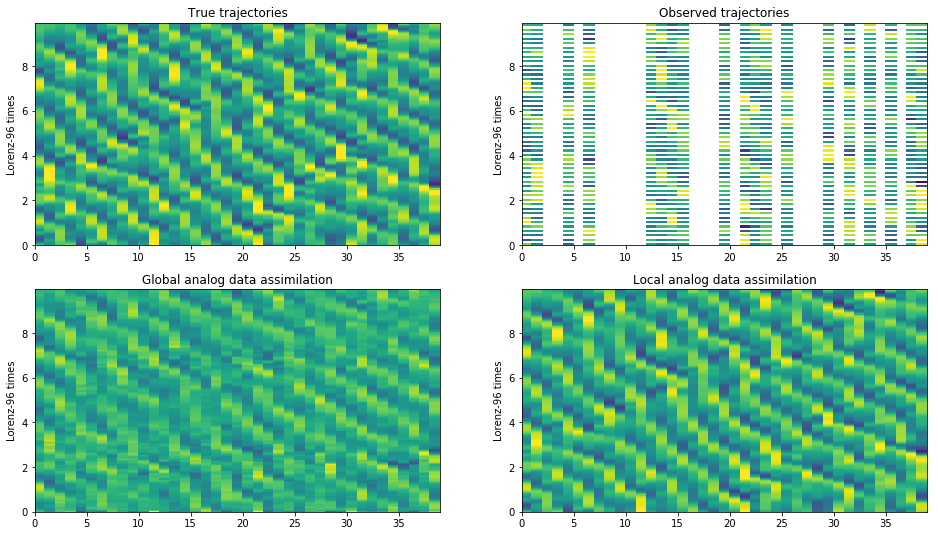

In [14]:
### COMPARISON BETWEEN GLOBAL AND LOCAL ANALOG DATA ASSIMILATION

# plot
[X,Y]=meshgrid(range(GD.parameters.J),xt.time)
subplot(2,2,1);pcolor(X,Y,xt.values);xlim([0,GD.parameters.J-1]);clim([-10,10]);ylabel('Lorenz-96 times');title('True trajectories')
subplot(2,2,2);pcolor(X,Y,ma.masked_where(isnan(yo.values),yo.values));xlim([0,GD.parameters.J-1]);clim([-10,10]);ylabel('Lorenz-96 times');title('Observed trajectories')
subplot(2,2,3);pcolor(X,Y,x_hat_analog_global.values);xlim([0,GD.parameters.J-1]);clim([-10,10]);ylabel('Lorenz-96 times');title('Global analog data assimilation')
subplot(2,2,4);pcolor(X,Y,x_hat_analog_local.values);xlim([0,GD.parameters.J-1]);clim([-10,10]);ylabel('Lorenz-96 times');title('Local analog data assimilation')

# error
print('RMSE(global analog DA) = ' + str(AnDA_RMSE(xt.values,x_hat_analog_global.values)))
print('RMSE(local analog DA)  = ' + str(AnDA_RMSE(xt.values,x_hat_analog_local.values)))

The results show that the global analog strategy do not reach satisfying results. Indeed, it is difficult to find relevant nearest neighboors on 40-dimensional vectors. The only way to improve the results in such a global strategy is to deeply increase the size of the catalog. At the contrary, in the local analog data assimilation, we are able to track correctly the true trajectories, even with a short catalog.

# Remark

Note that for all the previous experiments, we use the robust Ensemble Kalman Smoother (EnKS) with the increment or local linear regressions and the Gaussian sampling. If you want to have realistic state estimations, we preconize the use of the Particle Filter (DA.method = 'PF') with the locally constant regression (AF.regression = 'locally_constant') and the multinomial sampler (AF.sampling = 'multinomial') with a large number of particles (DA.N). For more details about the different options, see the attached publication: Lguensat, R., Tandeo, P., Ailliot, P., Pulido, M., & Fablet, R. (2017). The Analog Data Assimilation. *Monthly Weather Review*, 145(10), 4093-4107.